In [ ]:
# TASK 1 (ML eng. only)

# Imagine the digits in the test set of the MNIST dataset
# (http://yann.lecun.com/exdb/mnist/) got cut in half vertically and shuffled around. Although the
# two resulting halves of each image do not have any shared pixels, there are
# similarities in their structure. Implement a way to restore the original test
# set from the two halves, whilst maximising the overall matching accuracy.

my understanding of the problem: 
*   take the MNIST dataset (for example, train part with 60000 28*28 images),
*   divide every image into two parts vertically,
*   design some ML algorithm that is able to recover 60000 28*28 images having 120000 28*14 half-images  

What I've done:
*   wrote down a simple CNN that is making binary classification (i.e. true of fake image);
*   this CNN wgets as an input some 28*28 image generated via concatenation of some two half-images 28*14 and generates a label 0 <-> fake and 1 <-> real image;
*   for training I use 60000 MNIST 28*28 images as a real images and 60000 28*28 images generate from concatenation of shuffled 120000 28*14 half-images

{Such an approach is used for GAN's (I've picked up the discriminator part from a simple GAN).}


The general idea is to use a simple binary-classificator-CNN to train a model that understands if the 28*28 image is a mnist image or it is fake.

In [1]:
import numpy as np
from numpy import expand_dims
from numpy import ones, zeros
from numpy.random import rand, randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, LeakyReLU


def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(dataset, n_samples):
    # randomly choose n_samples indexes
    ix = np.random.choice(dataset.shape[0], n_samples)

    X_1 = dataset[ix][:, :, :14]
    X_2 = dataset[ix][:, :, 14:]

    X = np.concatenate([X_1, X_2])
    np.random.shuffle(X)

    X = np.concatenate([X[:n_samples], X[n_samples:]], axis = 2)
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# a simple CNN
def define_model(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3),  padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# train it
def train_model(model, dataset, n_iter=500, n_batch=256):
    half_batch = int(n_batch / 2)

    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update model on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(dataset, half_batch)
        # update model on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize the performance
        print('>%d real images acc=%.0f%% fake images acc=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the model
model = define_model()

# load image data
dataset = load_real_samples()

# fit the model
train_model(model, dataset)

>1 real images acc=67% fake images acc=18%
>2 real images acc=95% fake images acc=31%
>3 real images acc=93% fake images acc=48%
>4 real images acc=92% fake images acc=52%
>5 real images acc=91% fake images acc=54%
>6 real images acc=93% fake images acc=57%
>7 real images acc=95% fake images acc=58%
>8 real images acc=96% fake images acc=70%
>9 real images acc=92% fake images acc=66%
>10 real images acc=93% fake images acc=67%
>11 real images acc=91% fake images acc=67%
>12 real images acc=95% fake images acc=72%
>13 real images acc=93% fake images acc=73%
>14 real images acc=95% fake images acc=77%
>15 real images acc=91% fake images acc=71%
>16 real images acc=96% fake images acc=77%
>17 real images acc=97% fake images acc=80%
>18 real images acc=92% fake images acc=69%
>19 real images acc=93% fake images acc=74%
>20 real images acc=94% fake images acc=80%
>21 real images acc=97% fake images acc=79%
>22 real images acc=98% fake images acc=73%
>23 real images acc=92% fake images acc=8

As we see it is able to learn something. Let's take some examples and see how it performs.

array([[0.9622413]], dtype=float32)

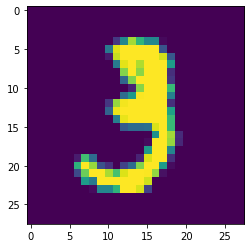

In [5]:
import matplotlib.pyplot as plt

some_image = dataset[10]
plt.imshow(some_image)
some_image = some_image.reshape(1,28,28,1)

model.predict(some_image)

96% of confidence that it's a MNIST image (it is).

Let's go further and generate a fake image:

In [6]:
randint(0, dataset.shape[0], 1)

array([19033])

array([[2.857564e-06]], dtype=float32)

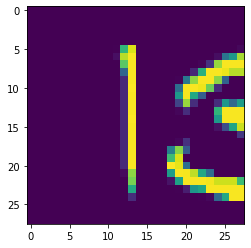

In [22]:
x_1 = dataset[14][:, :14]
x_2 = dataset[11232][:, :14]

some_image_2 = np.concatenate([x_1, x_2], axis=1).reshape(1,28,28,1)
plt.imshow(some_image_2[0])

model.predict(some_image_2)

This is fake, obviously (left half of one image with left half will almost always give a fake). But what about combining left half of one image with right half of another?

array([[0.09524855]], dtype=float32)

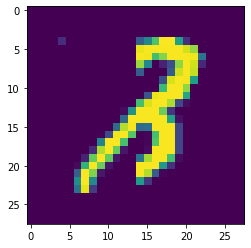

In [43]:
x_1 = dataset[1123][:, :14]
x_2 = dataset[157][:, 14:]

some_image_2 = np.concatenate([x_1, x_2], axis=1).reshape(1,28,28,1)
plt.imshow(some_image_2[0])

model.predict(some_image_2)

With high probability this is fake also. And it is! Cool!

However, there are some cases when algorithm will give 0.6, 0.7 for fake ones.

Further I do the following: 
* dividing the MNIST dataset into 2 parts vertically (generating 120000 28*14 images)
* concatenating, then shuffling
* arbitrarily picking one image (say image x) and successively concatinate it with all the 119999 images then predicting if the resulting image is fake or not. 

Of course this is not the best way to do, but as of limitation in time - let's do this MVP:

In [74]:
# dividing original dataset into 2 parts
X_1 = dataset[:, :, :14]
X_2 = dataset[:, :, 14:]

# print(X_1.shape, X_2.shape)

# concatenating and shuffling
X = np.concatenate([X_1, X_2])
np.random.shuffle(X)

In [91]:
# pick some image
our_image = X[128]

curr_proba = 0
best_proba = 0

i = 0
idx = -1

# here I take only first 1000 half-images just for an example, 
# it is a very-very unoptimized and takes huuuge time
for j in range(1000):
    i+=1
    curr_proba = model.predict(np.concatenate([our_image, X[j]], axis=1).reshape(1,28,28,1))
    if curr_proba > best_proba:
        best_proba = curr_proba
        idx = j
    if i % 100 == 0:
        print(i, best_proba, idx)

100 [[0.932423]] 73
200 [[0.932423]] 73
300 [[0.932423]] 73
400 [[0.932423]] 73
500 [[0.932423]] 73
600 [[0.932423]] 73
700 [[0.932423]] 73
800 [[0.932423]] 73
900 [[0.932423]] 73
1000 [[0.932423]] 73


Well, it says that our_image + X[73] is not a fake (and at least in the first 1000 half-plots this is the best match). Let's plot this:

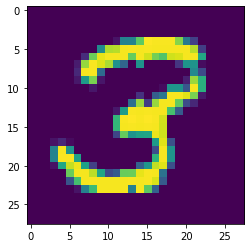

In [92]:
plt.imshow(np.concatenate([our_image, X[73]], axis = 1))

Nice! This seems to be realistic one. Take another case (just playing with it):

In [93]:
# pick another image
our_image_2 = X[12823]

curr_proba = 0
best_proba = 0

i = 0
idx = -1

for j in range(1000):
    i+=1
    curr_proba = model.predict(np.concatenate([our_image_2, X[j]], axis=1).reshape(1,28,28,1))
    if curr_proba > best_proba:
        best_proba = curr_proba
        idx = j
    if i % 100 == 0:
        print(i, best_proba, idx)

100 [[0.00179821]] 2
200 [[0.00211668]] 190
300 [[0.00397214]] 258
400 [[0.00455576]] 392
500 [[0.00455576]] 392
600 [[0.00455576]] 392
700 [[0.00455576]] 392
800 [[0.00455576]] 392
900 [[0.00455576]] 392
1000 [[0.00455576]] 392


Hmm, our image + everything in the first 1000 images is fake. Let's plot the best match:

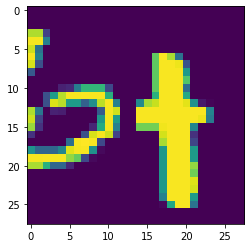

In [94]:
plt.imshow(np.concatenate([our_image_2, X[392]], axis = 1))

Ok, got it, this is fake (and everything where the left part will be a right part of the original will be apriori fake).

Well, seems that this works? ;)